In [ ]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

# Example Workflows - Model Optimization

>Basic model optimization workflow

## Model Optimization Workflows

This notebook shows a basic workflow for optimizing a generative model. The focus here is on showing how to set up the code, rather than maximizing performance. For this reason, we will use a simple template and a simple reward function.

## Performance Notes

The workflow in this notebook is more CPU-constrained than GPU-constrained due to the need to evaluate samples on CPU. If you have a multi-core machine, it is recommended that you uncomment and run the `set_global_pool` cells in the notebook. This will trigger the use of multiprocessing, which will result in 2-4x speedups.

This notebook may run slow on Collab due to CPU limitations.

If running on Collab, remember to change the runtime to GPU

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *
from mrl.model_zoo import *

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Agent

Here we create the model we want to optimize. We will use the `LSTM_LM_Small_ZINC` - a LSTM-based language model pretrained on part of the ZINC database

In [ ]:
agent = LSTM_LM_Small_ZINC(drop_scale=0.5,opt_kwargs={'lr':5e-5})

### Optional: Fine Tuning

We could optionally fine-tune the pretrained model on a dataset of interest. This is an example of how to add a dataset to a pretrained `Agent` and finetune

In [ ]:
# if in the repo
df = pd.read_csv('../files/smiles.csv')

# if in Collab
# download_files()
# df = pd.read_csv('files/smiles.csv')

In [ ]:
agent.update_dataset_from_inputs(df.smiles.values)
agent.train_supervised(64, 1, 1e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.45082,0.76565,00:03


## Template

We will set up a very basic template that will only check compounds for structural validity

In [ ]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter()],
                    [])

template_cb = TemplateCallback(template, prefilter=True)

## Reward

For the reward, we will load a scikit-learn linear regression model trained to predict affinity against erbB1 using molecular fingerprints.

This score function is extremely simple and won't translate well to affinity. It is used as a lightweight example

In [ ]:
class FP_Regression_Score():
    def __init__(self, fname):
        self.model = torch.load(fname)
        self.fp_function = partial(failsafe_fp, fp_function=ECFP6)
        
    def __call__(self, samples):
        mols = to_mols(samples)
        fps = maybe_parallel(self.fp_function, mols)
        fps = [fp_to_array(i) for i in fps]
        x_vals = np.stack(fps)
        preds = self.model.predict(x_vals)
        return preds
    
    
# if in the repo
reward_function = FP_Regression_Score('../files/erbB1_regression.sklearn')

# if in Collab
# download_files()
# reward_function = FP_Regression_Score('files/erbB1_regression.sklearn')

reward = Reward(reward_function, weight=1.)

aff_reward = RewardCallback(reward, 'aff')

## Loss Function

We will use the `PolicyGradient` class, the simplest policy gradient algorithm

In [ ]:
pg = PolicyGradient(discount=True, gamma=0.97)

loss = PolicyLoss(pg, 'PG')

### Optional: PPO

A more sophisticated policy gradient algorithm 

In [ ]:
# pg = PPO(0.99,
#         0.5,
#         lam=0.95,
#         v_coef=0.5,
#         cliprange=0.3,
#         v_cliprange=0.3,
#         ent_coef=0.01,
#         kl_target=0.03,
#         kl_horizon=3000,
#         scale_rewards=True)

# loss = PolicyLoss(pg, 'PPO', 
#                    value_head=ValueHead(256), 
#                    v_update_iter=2, 
#                    vopt_kwargs={'lr':1e-3})

## Samplers

We will use a basic sampler setup which will build the buffer from the main model and train only on samples from the buffer

In [ ]:
gen_bs = 1500
sampler1 = ModelSampler(agent.vocab, agent.model, 'live', 400, 0., gen_bs)
samplers = [sampler1]

### Optional: More Samplers

Samplers that draw from the base model and the log

In [ ]:
# sampler2 = ModelSampler(agent.vocab, agent.base_model, 'base', 400, 0., gen_bs)
# sampler3 = LogSampler('samples', 'rewards', 10, 97, 400)

# samplers += [sampler2, sampler3]

## Other Callbacks

We will add two callbacks for printing metrics

In [ ]:
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [live_p90, live_max]

## Environment

We create our environment with the objects assembled so far

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[aff_reward], losses=[loss],
                 cbs=cbs)

## Train

In [ ]:
# set_global_pool(cpus=min(10, os.cpu_count()))

In [ ]:
env.fit(128, 90, 500, 25)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,aff,PG,rewards_live_p90,rewards_live_max
0,5.355,5.355,1.000,1.000,128,0.000,1.000,5.355,-0.005,7.444,7.955
25,6.077,6.077,0.867,1.000,128,0.000,1.000,6.077,-0.011,7.367,8.335
50,5.816,5.816,0.867,1.000,128,0.000,1.000,5.816,-0.019,7.310,7.897
75,6.131,6.131,0.812,1.000,128,0.000,1.000,6.131,-0.037,7.292,8.511
100,6.276,6.276,0.750,1.000,128,0.000,1.000,6.276,-0.069,7.456,8.555
125,6.433,6.433,0.633,1.000,128,0.000,1.000,6.433,-0.053,6.863,8.195
150,6.578,6.578,0.703,1.000,128,0.000,1.000,6.578,-0.045,7.720,10.436
175,6.543,6.543,0.719,1.000,128,0.000,1.000,6.543,-0.009,7.591,9.904
200,6.834,6.834,0.594,1.000,128,0.000,1.000,6.834,-0.065,7.273,10.186
225,6.574,6.574,0.688,1.000,128,0.000,1.000,6.574,-0.020,7.564,9.487


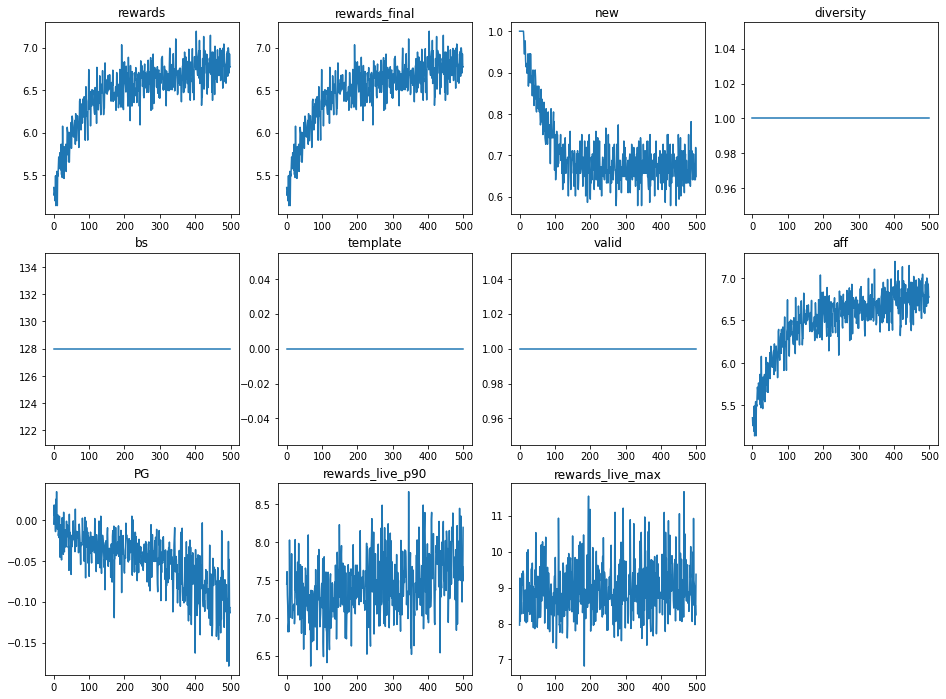

In [ ]:
env.log.plot_metrics()